In [ ]:
!pip install videodb openai markdown2

In [26]:
from videodb import connect
import os

os.environ["OPENAI_API_KEY"] = ""
os.environ["VIDEO_DB_API_KEY"] = ""

conn = connect()

In [2]:
coll = conn.get_collection()

In [3]:
# Upload a video by url
video = coll.upload(url="https://www.youtube.com/watch?v=QJNwK2uJyGs")

In [4]:
# Index spoken content
video.index_spoken_words()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.86it/s]


In [5]:
from videodb import SceneExtractionType

#TODO: Experiment Here

# Extract scenes using shot-based extraction
scene_collection = video.extract_scenes(
    extraction_type=SceneExtractionType.shot_based,
    extraction_config={"threshold": 10, "frame_count": 1}
)

In [9]:
print(scene_collection.scenes[0].frames[0].url)

https://storage.googleapis.com/videodb-dev.appspot.com/media/u-cc36fd41-567b-4ab5-8b05-d215437275f3/m-4d9036f1-207b-4768-a3ad-53d2e379cce6/frames/frm-scn-st10m15f1-0.0-25.867-12.933/img-13faa8d1-e43c-4c15-85ab-1fa29409359b.png


st10m15f1-0.0-25.867 : 0.0-25.867


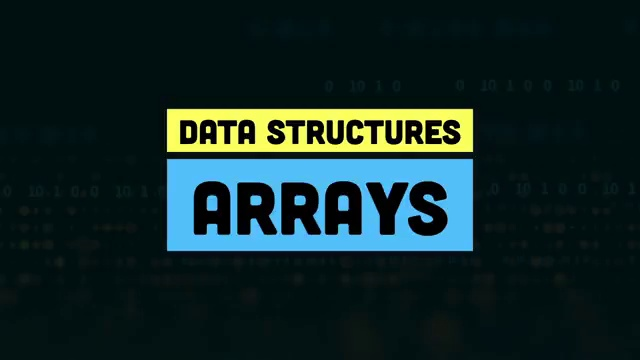

----
st10m15f1-25.867-32.033 : 25.867-32.033


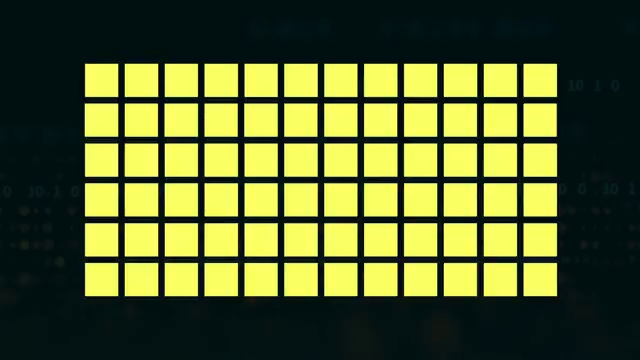

----
st10m15f1-32.033-60.767 : 32.033-60.767


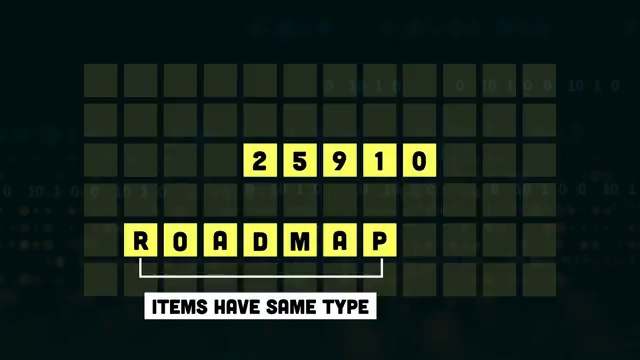

----
st10m15f1-60.767-109.133 : 60.767-109.133


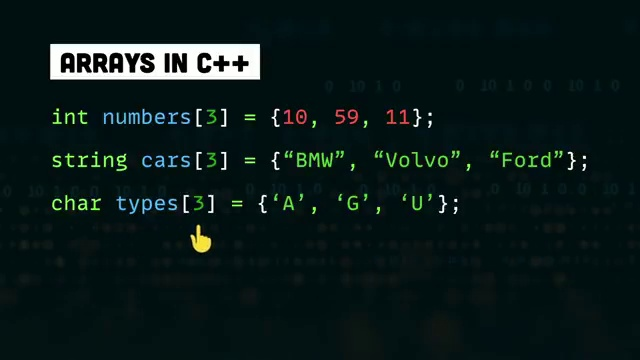

----
st10m15f1-109.133-115.567 : 109.133-115.567


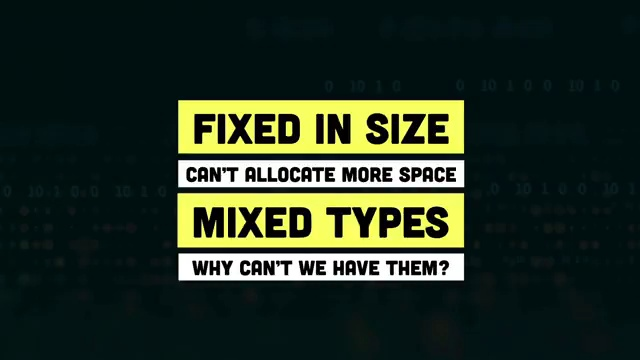

----
st10m15f1-115.567-122.1 : 115.567-122.1


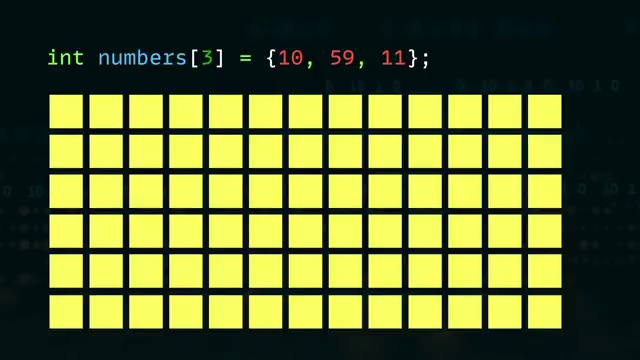

----
st10m15f1-122.1-192.667 : 122.1-192.667


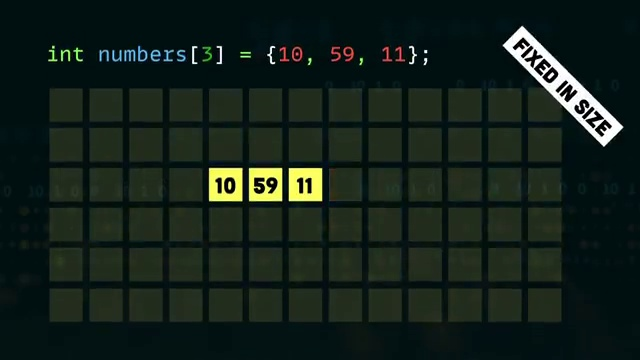

----
st10m15f1-192.667-202.467 : 192.667-202.467


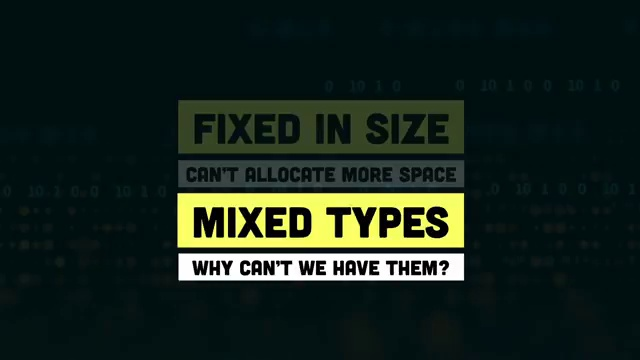

----
st10m15f1-202.467-218.6 : 202.467-218.6


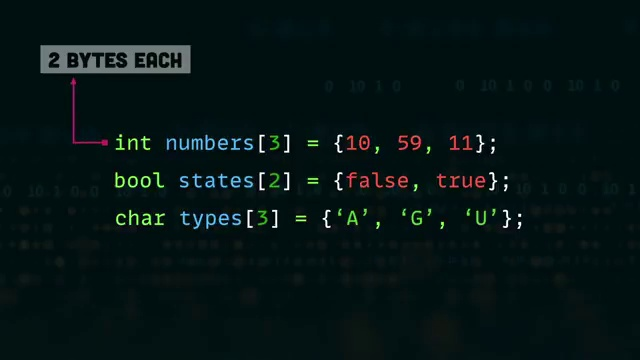

----
st10m15f1-218.6-300.033 : 218.6-300.033


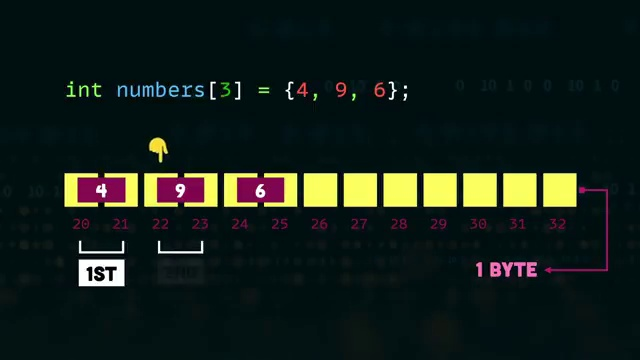

----
st10m15f1-300.0-317.7 : 300.0-317.7


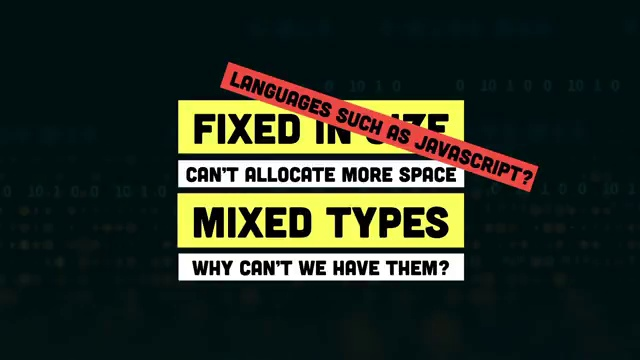

----
st10m15f1-317.7-321.067 : 317.7-321.067


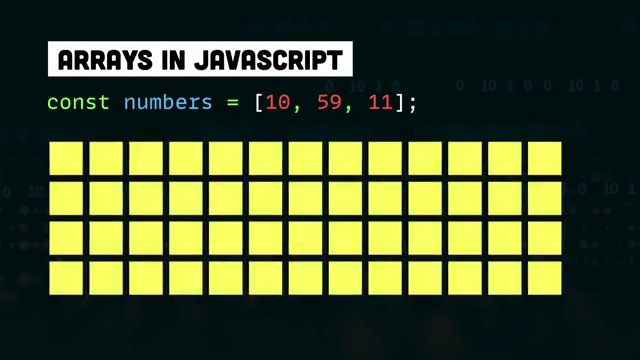

----
st10m15f1-321.067-379.6 : 321.067-379.6


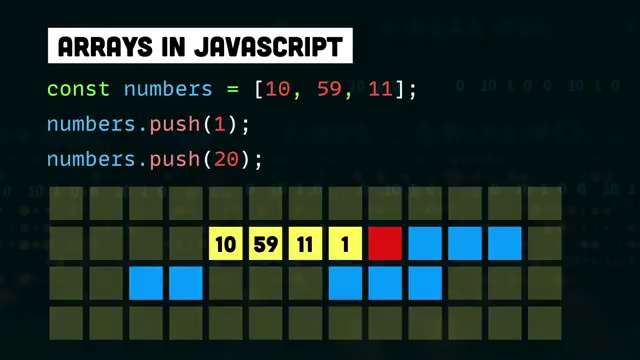

----
st10m15f1-379.6-422.167 : 379.6-422.167


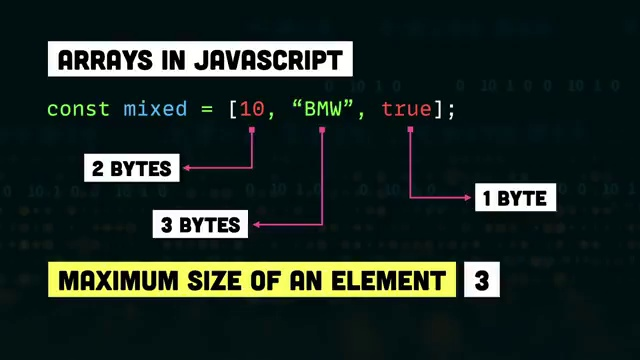

----
st10m15f1-422.167-434.633 : 422.167-434.633


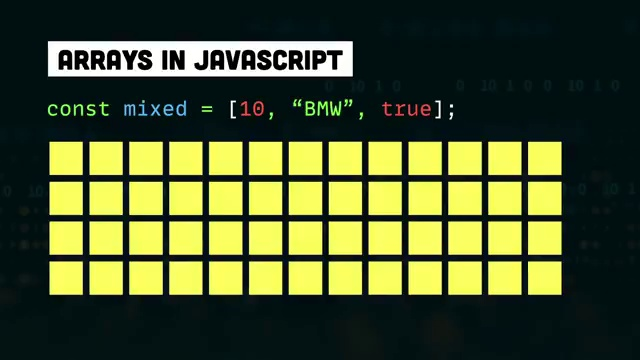

----
st10m15f1-434.633-471.967 : 434.633-471.967


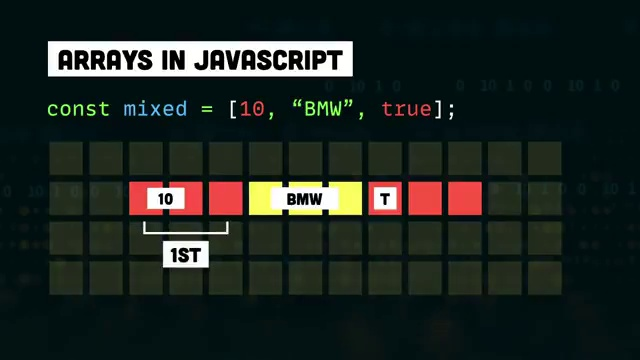

----
st10m15f1-471.967-478.5 : 471.967-478.5


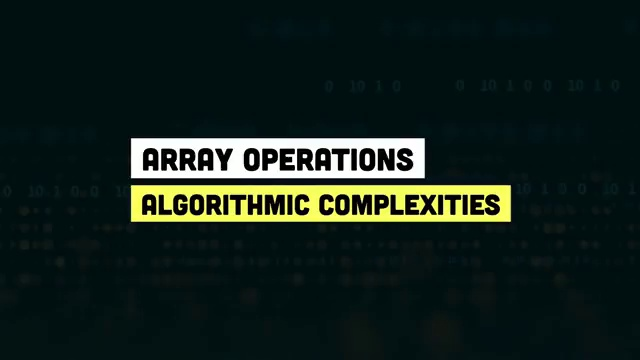

----
st10m15f1-478.5-516.9 : 478.5-516.9


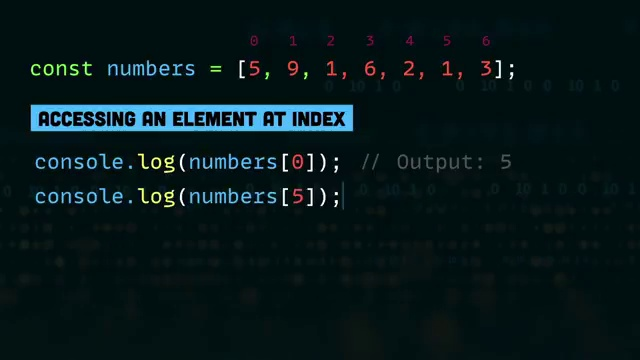

----
st10m15f1-516.9-586.3 : 516.9-586.3


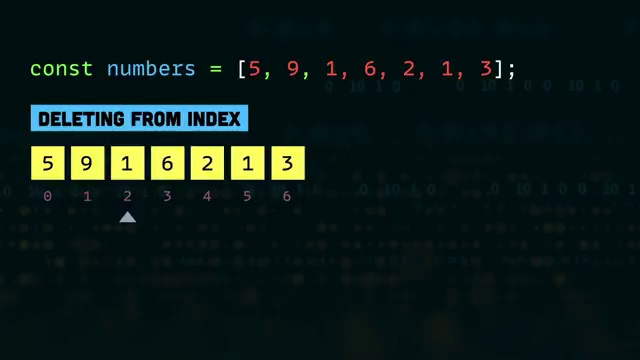

----
st10m15f1-586.3-596.133 : 586.3-596.133


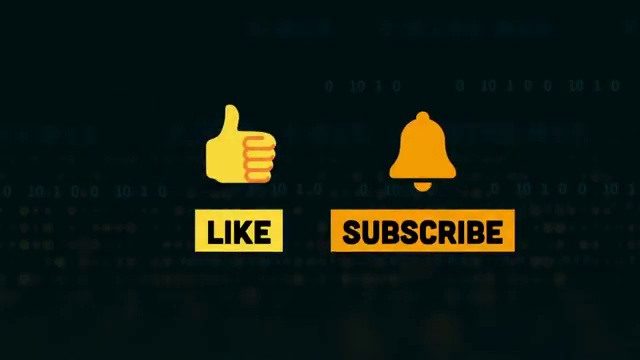

----


In [6]:
from IPython.display import Image, display
import requests


# Helper function that will help us view the Scene Collection Images
def display_scenes(scenes, images=True):
    for scene in scenes:
        print(f"{scene.id} : {scene.start}-{scene.end}")
        if images:
            for frame in scene.frames:
                # display(Image(data=image_data))
                im = Image(requests.get(frame.url, stream=True).content)
                display(im)
        print("----")


display_scenes(scene_collection.scenes)

In [10]:
index_id = video.index_scenes(
    extraction_type=SceneExtractionType.shot_based,
    extraction_config={"threshold": 10, "frame_count": 1}
)
scene_index = video.get_scene_index(index_id)

In [35]:
import openai
from IPython.display import HTML, display
import markdown2

summarize_prompt = f"""
Scene Description: {scene_description}
Scene Transcript: {scene_transcript}

Please create a concise summary note for this scene, combining the visual description and the spoken content.
Return the summary in Markdown format with proper headings
"""


def extract_transcript_for_scene(transcript, start_time, end_time):
    return " ".join(
        [item["text"] for item in transcript if start_time <= item["start"] < end_time]
    )


def summarize_scene(scene_description, scene_transcript):

    client = openai.Client()
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant that summarizes video scenes.",
            },
            {
                "role": "user",
                "content": summarize_prompt.format(
                    scene_description=scene_description,
                    scene_transcript=scene_transcript,
                ),
            },
        ],
    )

    return response.choices[0].message.content


def process_video(transcript, scenes):
    summarized_scenes = []

    for scene in scenes:
        scene_transcript = extract_transcript_for_scene(
            transcript, scene["start"], scene["end"]
        )
        summary = summarize_scene(scene["description"], scene_transcript)

        summarized_scenes.append(
            {
                "start": scene["start"],
                "end": scene["end"],
                "image_url": scene["image_url"],
                "summary": summary,
            }
        )

    return summarized_scenes



def create_summary_html(summaries):
    html_content = """
    <style>
        .summary-container { 
            display: flex; 
            overflow-x: auto; 
            padding: 20px 0;
            scroll-snap-type: x mandatory;
        }
        .summary-item { 
            flex: 0 0 auto; 
            width: 300px; 
            margin-right: 20px; 
            border: 1px solid #ddd; 
            padding: 15px; 
            scroll-snap-align: start;
        }
        .summary-item img { 
            width: 100%; 
            height: 180px; 
            object-fit: cover; 
        }
        .summary-item h3 { margin-top: 10px; }
        .markdown-body {
            font-family: Arial, sans-serif;
            line-height: 1.6;
            color: #333;
        }
    </style>
    <div class="summary-container">
    """
    
    for i, summary in enumerate(summaries, 1):
        markdown_summary = markdown2.markdown(summary['summary'])
        html_content += f"""
        <div class="summary-item">
            <img src="{summary['image_url']}" alt="Scene {i}" onerror="this.onerror=null;this.src='https://via.placeholder.com/300x180.png?text=Image+Not+Available';">
            <h3>Scene {i} ({summary['start']:.2f}s - {summary['end']:.2f}s)</h3>
            <div class="markdown-body">{markdown_summary}</div>
        </div>
        """
    
    html_content += "</div>"
    return html_content

def display_summaries(summaries):
    html = create_summary_html(summaries)
    display(HTML(html))

In [36]:
scenes = [
    {
        "start": scene.start,
        "end": scene.end,
        "image_url": scene.frames[0].url,
        "description": scene_index["description"],
    }
    for scene_index, scene in zip(scene_index, scene_collection.scenes)
]
transcript = video.get_transcript()
summary = process_video(transcript, scenes)
display_summaries(summary)